## Assignment 2

### Team 3

 - Scott Brewer (sbrewe5@uic.edu)
 - Rahul Shukla (rshukl4@uic.edu)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
%config IPCompleter.greedy = True
random_seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010])

train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize])
    
val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize])

In [4]:
# Download untransformed train and test data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=val_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
print('trainset is',
      type(trainset),'of',
      len(trainset),
      type(trainset[0]),'of',
      type(trainset[0][0]),'and',
      type(trainset[0][1]))
print()
print('testset is',
      type(testset),'of',
      len(testset),
      type(testset[0]),'of',
      type(testset[0][0]),'and',
      type(testset[0][1]))

trainset is <class 'torchvision.datasets.cifar.CIFAR10'> of 50000 <class 'tuple'> of <class 'torch.Tensor'> and <class 'int'>

testset is <class 'torchvision.datasets.cifar.CIFAR10'> of 10000 <class 'tuple'> of <class 'torch.Tensor'> and <class 'int'>


In [42]:
# Split train data in to train and validation data using torch dataset and utils.data modules

val_size = .2
n_train = len(trainset)

# get train set indices and split point based on val size
indices = list(range(n_train))
split = int(np.floor(val_size * n_train))

# shuffle trainset indices
np.random.seed(random_seed)
np.random.shuffle(indices)

# split train into train and val with shuffled indices at split point. 
train_idx, val_idx = indices[split:], indices[:split]

# Create train and val samplers based in split indices for use with DataLoader batch sampling
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

batch_size = 100
n_trn = n_train*(1-val_size)
batches = n_trn/batch_size

# CUDA settings
num_workers = 3 # allows preload of next batch
pin_memory = True

train_dl = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

val_dl = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

def single_dl(xy, batch_size=1):
    return torch.utils.data.DataLoader(xy, batch_size=batch_size, num_workers=1, pin_memory=pin_memory)

In [7]:
classes = trainset.classes
classdict = {label: name for label, name in enumerate(classes)}
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
def process_img(inp):
    """preprocess PIL file for plt.imshow."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

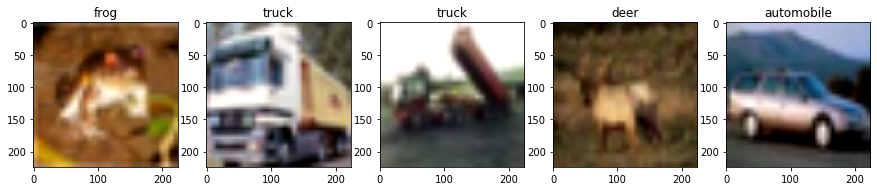

In [9]:
# View a few images
nrows, ncols = 1, 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,4))
axs = np.ravel(axs)
for img in range(nrows*ncols):
    axs[img].set_title(classdict[trainset[img][1]])
    axs[img].imshow(process_img(trainset[img][0]))

In [10]:
# %load my_train_helper.py
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False
        
def model_summary(model):
    print('{:20}Trainable'.format(model.__class__.__name__))
    for child in model_ft.children():
        try:
            print('{:20}{}'.format(child.__class__.__name__, child.weight.requires_grad))
        except:
            print('{:20}'.format(child.__class__.__name__))

        if type(child) == nn.Sequential:
            for child_seq in child.children():
                print('  {:18}'.format(child_seq.__class__.__name__))
                for child_blk in child_seq.children():
                    try:
                        print('    {:16}{}'.format(child_blk.__class__.__name__, child_blk.weight.requires_grad))
                    except:
                        print('    {:16}'.format(child_blk.__class__.__name__))



In [101]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    correct = 0
    output = model(xb)
    _, preds = torch.max(output, 1)
    correct = torch.sum(preds == yb)
    acc = correct.double()/len(yb)
    loss = loss_func(output, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), acc   

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    mod = n_trn/(batch_size*20)
    running_corrects = 0
    for epoch in range(epochs):
        since = time.time()
        model.train()
        i=0
        print('Epoch {}/{}: ['.format(epoch+1, epochs), end='')
        for xb, yb in train_dl:
            if i%mod == 0: print('*', end='')
            loss_batch(model, loss_func, xb, yb, opt)
            i+=1
        print(']', end='')
        model.eval()
        print(' Val Loss: ', end='')
        with torch.no_grad():
            losses, nums, acc = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)
        #val_corr = np.sum(preds[1].item() == yb.item())
        #val_acc = val_corr.double() / len(yb)

        print('{:6.4f}, Val Acc: {:6.4f} '.format(val_loss, val_acc), end='')
        until = time.time()
        print('Elapsed (sec): {:<5.1f}'.format(until-since))

In [102]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

epochs = 10
model_ft = model_ft.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [103]:
model_summary(model_ft)

ResNet              Trainable
Conv2d              True
BatchNorm2d         True
ReLU                
MaxPool2d           
Sequential          
  BasicBlock        
    Conv2d          True
    BatchNorm2d     True
    ReLU            
    Conv2d          True
    BatchNorm2d     True
  BasicBlock        
    Conv2d          True
    BatchNorm2d     True
    ReLU            
    Conv2d          True
    BatchNorm2d     True
Sequential          
  BasicBlock        
    Conv2d          True
    BatchNorm2d     True
    ReLU            
    Conv2d          True
    BatchNorm2d     True
    Sequential      
  BasicBlock        
    Conv2d          True
    BatchNorm2d     True
    ReLU            
    Conv2d          True
    BatchNorm2d     True
Sequential          
  BasicBlock        
    Conv2d          True
    BatchNorm2d     True
    ReLU            
    Conv2d          True
    BatchNorm2d     True
    Sequential      
  BasicBlock        
    Conv2d          True
    BatchNorm2d  

In [104]:
freeze_all(model_ft.parameters())
model_ft.fc.weight.requires_grad = True
model_summary(model_ft)

ResNet              Trainable
Conv2d              False
BatchNorm2d         False
ReLU                
MaxPool2d           
Sequential          
  BasicBlock        
    Conv2d          False
    BatchNorm2d     False
    ReLU            
    Conv2d          False
    BatchNorm2d     False
  BasicBlock        
    Conv2d          False
    BatchNorm2d     False
    ReLU            
    Conv2d          False
    BatchNorm2d     False
Sequential          
  BasicBlock        
    Conv2d          False
    BatchNorm2d     False
    ReLU            
    Conv2d          False
    BatchNorm2d     False
    Sequential      
  BasicBlock        
    Conv2d          False
    BatchNorm2d     False
    ReLU            
    Conv2d          False
    BatchNorm2d     False
Sequential          
  BasicBlock        
    Conv2d          False
    BatchNorm2d     False
    ReLU            
    Conv2d          False
    BatchNorm2d     False
    Sequential      
  BasicBlock        
    Conv2d          

In [105]:
fit(epochs, model_ft, loss_func, opt, train_dl, val_dl)

Epoch 1/10: [********************] Val Loss: 0.7867, Val Acc: 0.7591 Elapsed (sec): 39.0 
Epoch 2/10: [********************] Val Loss: 0.6820, Val Acc: 0.7782 Elapsed (sec): 39.6 
Epoch 3/10: [********************] Val Loss: 0.6396, Val Acc: 0.7893 Elapsed (sec): 40.1 
Epoch 4/10: [********************] Val Loss: 0.6195, Val Acc: 0.7903 Elapsed (sec): 40.7 
Epoch 5/10: [********************] Val Loss: 0.6083, Val Acc: 0.7917000000000001 Elapsed (sec): 40.8 
Epoch 6/10: [********************] Val Loss: 0.5966, Val Acc: 0.7977000000000001 Elapsed (sec): 41.0 
Epoch 7/10: [********************] Val Loss: 0.5845, Val Acc: 0.8025 Elapsed (sec): 41.0 
Epoch 8/10: [********************] Val Loss: 0.5798, Val Acc: 0.8001 Elapsed (sec): 41.0 
Epoch 9/10: [********************] Val Loss: 0.5780, Val Acc: 0.8026000000000001 Elapsed (sec): 40.7 
Epoch 10/10: [********************] Val Loss: 0.5737, Val Acc: 0.8025 Elapsed (sec): 41.0 


In [95]:
model_ft.eval()
xb, yb = single_dl(valset[0])
loss, num, acc = loss_batch(model_ft, loss_func, xb, yb)
print('yb: {}, acc: {}'.format(yb.item(),acc.item()))

yb: 6, acc: 1


In [37]:
loss, num, pred = loss_batch(model_ft, loss_func, xb, yb)
print('yb: {}, pred: {}'.format(yb.item(),pred[1].item()))

yb: 6, pred: 6


In [107]:

    
net = ExtractNet()

In [125]:
class Identity(nn.Module):
    """Identity class designed to 'delete' a layer in a pretrained convnet"""
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def extract_features(model, dl, sample_count):
    """Extracts features from convbase. Must 'delete' final fc layer first"""
    features = np.zeros(shape=(sample_count, 512))
    labels = np.zeros(shape=(sample_count))
    i=0
    model.to(device)
    for xb, yb in dl:
        if i%20==0: print('Batch:',i)
        xb = xb.to(device)
        out_b = model(xb)
        out_b = out_b.to('cpu')
        features[i * batch_size : (i + 1) * batch_size] = out_b
        labels[i * batch_size : (i + 1) * batch_size] = yb
        i += 1
    return features, labels

class ExtractNet(nn.Module):
    """Simple Dense layer with softmax to make use of convnet extracted features"""
    def __init__(self):
        super(ExtractNet, self).__init__()
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.fc(nn.Softmax(x))
        return x

In [126]:
model_ex = models.resnet18(pretrained=True)
model_ex.fc = Identity()
freeze_all(model_ex.parameters())
train_features, train_labels = extract_features(model_ex, train_dl, len(train_idx))
val_features, val_labels = extract_features(model_ex, val_dl, len(val_idx))

Batch: 0
Batch: 20
Batch: 40
Batch: 60
Batch: 80
Batch: 100
Batch: 120
Batch: 140
Batch: 160
Batch: 180
Batch: 200
Batch: 220
Batch: 240
Batch: 260
Batch: 280
Batch: 300
Batch: 320
Batch: 340
Batch: 360
Batch: 380
Batch: 0
Batch: 20
Batch: 40
Batch: 60
Batch: 80


In [133]:
train_ext = zip(torch.tensor(train_features), torch.tensor(train_labels))
val_ext = zip(torch.tensor(val_features), torch.tensor(val_labels))
print(type(train_ext))

train_ext_dl = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

val_ext_dl = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

epochs = 10
model_lin = ExtractNet()
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
fit(epochs, model_lin, loss_func, opt, train_ext_dl, val_ext_dl)

<class 'zip'>
Epoch 1/10: [*

TypeError: 'Tensor' object is not callable

In [55]:
def predict(model, data, batch_size=100):
    #dl = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=3, pin_memory=pin_memory)
    correct = 0
    preds=[]
    model.to(device)
    model.eval()
    with torch.no_grad():
        losses, nums, preds = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in data])
        correct += torch.sum(preds == yb)
        acc = correct/len(data)
    return acc, correct, len(data)

In [ ]:
        with torch.no_grad():
            losses, nums, preds = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_corr = np.sum(preds[1].item() == yb.item())
        val_acc = val_corr.double() / len(yb)

In [26]:
model_ft.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE
import torch.optim as optim

In [71]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [72]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [73]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=20,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Using the trainloader we will now get a random batch of 4 training images and plot them to see what CIFAR-10 images look like.



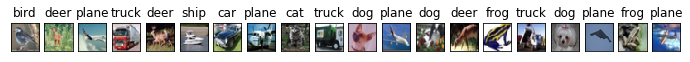

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [75]:
from torch.utils.data import DataLoader
batch_size = 2

train_dl = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

val_dl = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
)

In [76]:
from torchvision import models

model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [77]:
# Freeze all parameters manually
for param in model.parameters():
    param.requires_grad = False

In [43]:
# %load my_train_helper.py
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [79]:
# Freeze all parameters manually
for param in model.parameters():
    param.requires_grad = False

In [80]:
# Or use our convenient functions from before
freeze_all(model.parameters())
assert all_frozen(model.parameters())

In [81]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

Since we are classifying images into more than two classes we will use cross-entropy as a loss function. To optimize the network we will employ stochastic gradient descent (SGD) with momentum to help get us over local minima and saddle points in the loss function space.

In [82]:
criterion = nn.CrossEntropyLoss()

In [83]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

We will now train the network using the trainloader data, by going over all the training data in batches of 4 images, and repeating the whole process 2 times, i.e., 2 epochs. Every 2000 batches we report on training progress by printing the current epoch and batch number along with the running loss value.

Once training is complete, we will save the model parameters to disk. This will make it possible to load the model parameters from disk the next time we run this notebook and thus not have to train the model again, saving some time

In [84]:
import os

model_directory_path = './data'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

Loaded model parameters from disk.


Now that the network is trained we can evaluate how it performs on the testing data set. Let us load four random images from the testing data set and their corresponding labels.

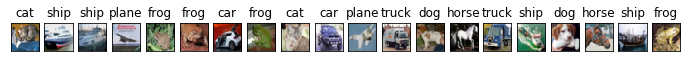

In [85]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [86]:
outputs = net(images)

In [87]:
outputs

tensor([[-4.1309e-01, -1.7897e+00,  4.3204e-01,  1.4343e+00,  2.6835e-01,
          7.8584e-01,  1.0871e+00, -6.5214e-01,  2.3735e-02, -1.3776e+00],
        [ 3.5181e+00,  6.3610e+00, -1.3378e+00, -2.2894e+00, -2.6873e+00,
         -4.8203e+00, -4.3636e+00, -3.9625e+00,  7.1261e+00,  3.1569e+00],
        [ 2.1426e+00,  2.3195e+00, -4.4099e-01, -5.9431e-01, -1.4700e+00,
         -2.1091e+00, -2.3772e+00, -2.2029e+00,  4.0455e+00,  1.1479e+00],
        [ 3.4598e+00,  1.7771e+00,  5.2079e-01, -1.1499e+00, -1.0490e+00,
         -2.9148e+00, -1.9754e+00, -2.1868e+00,  3.3149e+00,  1.1640e+00],
        [-2.4056e+00, -2.8966e+00,  1.5726e+00,  1.0876e+00,  3.4491e+00,
          8.1648e-01,  3.1899e+00,  1.2588e-02, -2.9224e+00, -3.4530e+00],
        [-6.8507e-03, -3.8551e-01,  9.5482e-01, -3.9008e-01,  1.0974e+00,
         -1.2489e+00,  3.8845e+00, -2.4352e+00, -6.2328e-01, -1.2098e+00],
        [ 2.4738e-01,  2.4945e+00, -1.9151e-01, -2.3630e-01, -1.4953e+00,
         -7.7646e-01, -6.1399e-0

In [90]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[4.4611e-02, 1.1261e-02, 1.0387e-01, 2.8298e-01, 8.8183e-02, 1.4796e-01,
         1.9997e-01, 3.5125e-02, 6.9048e-02, 1.7004e-02],
        [1.7932e-02, 3.0780e-01, 1.3956e-04, 5.3882e-05, 3.6197e-05, 4.2886e-06,
         6.7711e-06, 1.0113e-05, 6.6152e-01, 1.2496e-02],
        [1.0555e-01, 1.2598e-01, 7.9693e-03, 6.8365e-03, 2.8480e-03, 1.5031e-03,
         1.1496e-03, 1.3685e-03, 7.0776e-01, 3.9036e-02],
        [4.4741e-01, 8.3156e-02, 2.3675e-02, 4.4537e-03, 4.9266e-03, 7.6248e-04,
         1.9507e-03, 1.5790e-03, 3.8704e-01, 4.5045e-02],
        [1.3454e-03, 8.2342e-04, 7.1878e-02, 4.4253e-02, 4.6938e-01, 3.3745e-02,
         3.6220e-01, 1.5104e-02, 8.0244e-04, 4.7207e-04],
        [1.7184e-02, 1.1767e-02, 4.4953e-02, 1.1713e-02, 5.1840e-02, 4.9626e-03,
         8.4163e-01, 1.5153e-03, 9.2768e-03, 5.1603e-03],
        [4.9756e-02, 4.7071e-01, 3.2081e-02, 3.0675e-02, 8.7096e-03, 1.7873e-02,
         2.1026e-02, 1.1290e-02, 1.1938e-01, 2.3850e-01],
        [8.4097e-02, 1.0149

In [91]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.2830
ship - 0.6615
ship - 0.7078
plane - 0.4474
deer - 0.4694
frog - 0.8416
car - 0.4707
frog - 0.3779
dog - 0.4666
car - 0.8697
deer - 0.3593
truck - 0.5308
frog - 0.5203
horse - 0.9845
truck - 0.4766
frog - 0.3200
dog - 0.4338
deer - 0.2326
ship - 0.9413
deer - 0.3525


The model got half of the twenty testing images correct. It correctly categorised the frog and car,horse images, but failed on the two ship images, instead categorising them as cars. Let us now evaluate the model on the whole testing set.

In [92]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 53.26%


In [93]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:20s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane                - 49.4
car                  - 77.6
bird                 - 43.3
cat                  - 29.4
deer                 - 43.2
dog                  - 39.9
frog                 - 62.1
horse                - 58.2
ship                 - 77.5
truck                - 52.0


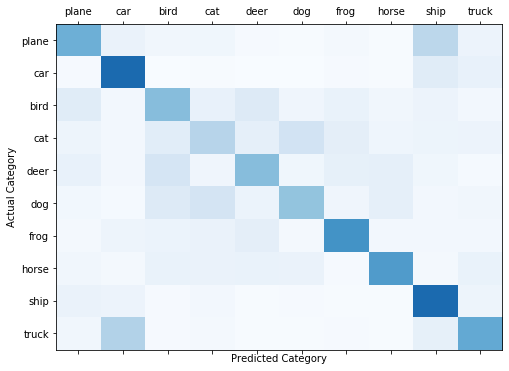

In [94]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

From the above visualisation we can see that the best accuracy was achieved on the car and ship categories, darkest shades present on the main diagonal. The truck category was most frequently confused with the car category. This is understandable, since they are both vehicles and have some visual similarities. Planes were also commonly confused with bird and ship

To understand precisely which categories were most commonly confused, we can print the absolute and relative values of the confusion matrix, as follows

In [95]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           494       63        33        38        9         4         16        5         280       58        
                0.494     0.063     0.033     0.038     0.009     0.004     0.016     0.005     0.28      0.058     
car             11        776       3         4         2         2         8         4         115       75        
                0.011     0.776     0.003     0.004     0.002     0.002     0.008     0.004     0.115     0.075     
bird            117       26        433       74        126       41        68        34        55        26        
                0.117     0.026     0.433     0.074     0.126     0.041     0.068     0.034     0.055     0.026     
cat             50        26        108       294       88        184       95        45        53        57        
                0.05      0.026     0.108     0.294     0.088   

The model performed well, achieving an accuracy of 52.2% compared to a baseline of 10%, since there are 10 categories in CIFAR-10, if the model guessed randomly.

To improve the performance we can try adding convolution layers, more filters or more fully connected layers. We could also train the model for more than two epochs while introducing some form of regularisation, such as dropout or batch normalization, so as not to overfit the training data.

3. Finetune the  model’s parameters suitably and comparison

In [96]:
import os

model_directory_path = './data'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(12):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

Loaded model parameters from disk.


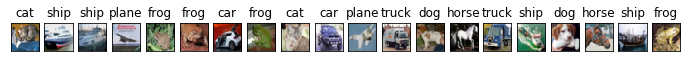

In [97]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [98]:
outputs = net(images)
outputs

tensor([[-4.1309e-01, -1.7897e+00,  4.3204e-01,  1.4343e+00,  2.6835e-01,
          7.8584e-01,  1.0871e+00, -6.5214e-01,  2.3735e-02, -1.3776e+00],
        [ 3.5181e+00,  6.3610e+00, -1.3378e+00, -2.2894e+00, -2.6873e+00,
         -4.8203e+00, -4.3636e+00, -3.9625e+00,  7.1261e+00,  3.1569e+00],
        [ 2.1426e+00,  2.3195e+00, -4.4099e-01, -5.9431e-01, -1.4700e+00,
         -2.1091e+00, -2.3772e+00, -2.2029e+00,  4.0455e+00,  1.1479e+00],
        [ 3.4598e+00,  1.7771e+00,  5.2079e-01, -1.1499e+00, -1.0490e+00,
         -2.9148e+00, -1.9754e+00, -2.1868e+00,  3.3149e+00,  1.1640e+00],
        [-2.4056e+00, -2.8966e+00,  1.5726e+00,  1.0876e+00,  3.4491e+00,
          8.1648e-01,  3.1899e+00,  1.2588e-02, -2.9224e+00, -3.4530e+00],
        [-6.8507e-03, -3.8551e-01,  9.5482e-01, -3.9008e-01,  1.0974e+00,
         -1.2489e+00,  3.8845e+00, -2.4352e+00, -6.2328e-01, -1.2098e+00],
        [ 2.4738e-01,  2.4945e+00, -1.9151e-01, -2.3630e-01, -1.4953e+00,
         -7.7646e-01, -6.1399e-0

In [99]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[4.4611e-02, 1.1261e-02, 1.0387e-01, 2.8298e-01, 8.8183e-02, 1.4796e-01,
         1.9997e-01, 3.5125e-02, 6.9048e-02, 1.7004e-02],
        [1.7932e-02, 3.0780e-01, 1.3956e-04, 5.3882e-05, 3.6197e-05, 4.2886e-06,
         6.7711e-06, 1.0113e-05, 6.6152e-01, 1.2496e-02],
        [1.0555e-01, 1.2598e-01, 7.9693e-03, 6.8365e-03, 2.8480e-03, 1.5031e-03,
         1.1496e-03, 1.3685e-03, 7.0776e-01, 3.9036e-02],
        [4.4741e-01, 8.3156e-02, 2.3675e-02, 4.4537e-03, 4.9266e-03, 7.6248e-04,
         1.9507e-03, 1.5790e-03, 3.8704e-01, 4.5045e-02],
        [1.3454e-03, 8.2342e-04, 7.1878e-02, 4.4253e-02, 4.6938e-01, 3.3745e-02,
         3.6220e-01, 1.5104e-02, 8.0244e-04, 4.7207e-04],
        [1.7184e-02, 1.1767e-02, 4.4953e-02, 1.1713e-02, 5.1840e-02, 4.9626e-03,
         8.4163e-01, 1.5153e-03, 9.2768e-03, 5.1603e-03],
        [4.9756e-02, 4.7071e-01, 3.2081e-02, 3.0675e-02, 8.7096e-03, 1.7873e-02,
         2.1026e-02, 1.1290e-02, 1.1938e-01, 2.3850e-01],
        [8.4097e-02, 1.0149

In [100]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))
    

cat - 0.2830
ship - 0.6615
ship - 0.7078
plane - 0.4474
deer - 0.4694
frog - 0.8416
car - 0.4707
frog - 0.3779
dog - 0.4666
car - 0.8697
deer - 0.3593
truck - 0.5308
frog - 0.5203
horse - 0.9845
truck - 0.4766
frog - 0.3200
dog - 0.4338
deer - 0.2326
ship - 0.9413
deer - 0.3525


In [101]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 53.26%


In [102]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 49.4
car        - 77.6
bird       - 43.3
cat        - 29.4
deer       - 43.2
dog        - 39.9
frog       - 62.1
horse      - 58.2
ship       - 77.5
truck      - 52.0


In [103]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           494       63        33        38        9         4         16        5         280       58        
                0.494     0.063     0.033     0.038     0.009     0.004     0.016     0.005     0.28      0.058     
car             11        776       3         4         2         2         8         4         115       75        
                0.011     0.776     0.003     0.004     0.002     0.002     0.008     0.004     0.115     0.075     
bird            117       26        433       74        126       41        68        34        55        26        
                0.117     0.026     0.433     0.074     0.126     0.041     0.068     0.034     0.055     0.026     
cat             50        26        108       294       88        184       95        45        53        57        
                0.05      0.026     0.108     0.294     0.088   

In our case accuracy has not improved

## 2. Movie embeddings (40pt)

#### 2.1. Compute data Xi,j from the movielens (small) dataset (data and description). Briefly describe your data prep workflow (you can use pandas if needed).

The processing stategy to transform data follows:  
1) Download ml-latest-small and unzip ratings and movie csv files  
2) Calculate median rating per user to use as baseline for likes  
3) Join user_medians df with ratings df and then create new 'liked' using rating >= median as a like  
4) Drop unneeded columns from result df: ['timestamp','median','rating']  
5) Use pd.merge to perform left join of movie df to new rating df to ensure all movies are included (even unrated ones)  
6) Use pd.pivot_table to create a user vs movie matrix with values as likes. Essentially each row is a vector of each user's liked movies. Again, ensure all movies are included.  
7) Perform dot product of pivot result with itself to get a matrix of MxM containing overlapping like counts for each movie pair  

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt

In [32]:
# Set seed
random.seed(0)

# Check and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
# Import ratings and movies data into pandas dataframes
datapath = '/home/team3/HW2/ml-latest-small/'
ratings = pd.read_csv(datapath+'ratings.csv',encoding='utf-8')
movies = pd.read_csv(datapath+'movies.csv',encoding='utf-8')

In [34]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [35]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [36]:
# Rename imported dataframes to preserve original and to shorten names for easier typing
df_r = ratings
df_m = movies

# Determine total user and movie counts
movie_ids = df_m['movieId']
movie_titles = df_m['title']
movie_idxs = df_m.index
n_user = len(df_r['userId'].unique())
n_movie = len(movie_ids)
print('Movie Count:', n_movie, len(movie_ids), len(movie_titles), len(movie_idxs))
print('User Count:', n_user)

Movie Count: 9742 9742 9742 9742
User Count: 610


In [37]:
# Create dict to lookup titles from indices later
index2movietitle = {i: m for i, m in enumerate(movie_titles)}

In [38]:
# Get statistics on ratings. At this point, we could just use the 50% or mean as the baseline for likes
df_r['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [39]:
# Determine median rating for each user and then join result with ratings df to cater likes to each user
user_medians = df_r.groupby(['userId']).rating.agg(['median'])
df_r = df_r.set_index('userId').join(user_medians)

# Create new column 'liked' where a like is a rating >= to a user's median rating in joined table
df_r['liked'] = np.where(df_r['rating'] >= df_r['median'], 1, 0)

In [40]:
# Now that liked has been determined, remove unneeded cols
df_r = df_r.drop(['timestamp','median','rating'], axis=1)
df_r.head()

,movieId,liked
userId,,
1,1,0
1,3,0
1,6,0
1,47,1
1,50,1


In [41]:
# Create userId column from index so that it's preserved after the join
df_r['userId'] = df_r.index

# Left join to ensure all movies included, even those unrated
df_rm = pd.merge(df_m, df_r, on='movieId', how='left')
len(df_rm['movieId'].unique())

9742

In [42]:
# Pivot on the joined dataframe to get users vs movies with 1s noted for liked movies, then move result to tensor on gpu for faster dot product
df_um = df_rm.pivot_table(index='userId', columns='movieId', values='liked', fill_value=0, dropna=False)
df_um = torch.tensor(df_um.values, dtype=torch.float).to(device)
print(df_um.size(), df_um.dtype, df_um.type())

torch.Size([610, 9742]) torch.float32 torch.cuda.FloatTensor


In [47]:
# Dot product user vs movies transpose and itself to get sum of likes at each movie i,j position
# Using torch and gpu to speed it up
X = df_um.transpose(0,1) @ df_um
print(X.size(), X.dtype, X.type(), X.requires_grad)

torch.Size([9742, 9742]) torch.float32 torch.cuda.FloatTensor False


#### 2.2. Optimize function c(v1, ..., vM ) over v1, ..., vM using gradient descent (using pytorch or tensorflow). Plot the loss as a function of iteration for various choices (learning rates, choice of optimizers etc).

Below we extend the nn.Module to initialize our embedding tensor and to return the cost function. We also define a fit function and a plot function to minimize code reuse over several experiments

In [91]:
class MovieCost(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(100, n_movie))

    def forward(self, X):
        raw = ((self.weights.transpose(0,1) @ self.weights - X)**2)
        dia = raw * torch.eye(n_movie, n_movie).to(device)
        return torch.sum(raw - dia)

In [92]:
def fit(X, model, opt, epochs):
    costs =[]
    for epoch in range(epochs):
        cost = model.forward(X)
        cost.backward()
        opt.step()
        opt.zero_grad()
        if epoch % 20 == 0:
              print('Step',epoch,'Cost',cost.item())
        costs.append(cost.item())
    return costs

def plot_experiment(costs, steps, options, title, colors, cumulative=False):
    plt.title(title+' Experiment')
    plt.xlabel('Gradient Descent Iterations')
    plt.ylabel('Log(Cost)')
    all_steps = steps
    for cost, option, color in zip(costs, options, colors):
        start = all_steps - steps
        plt.plot(np.arange(start,all_steps), np.log(cost), color, label=option)
        if cumulative:
            all_steps += steps
    plt.legend()

In [76]:
# Try SGD with several LRs
epochs = 100
lrs = [.00002, .00001, .000005]
costs =[]
for lr in lrs:
    model = MovieCost()
    model.to(device)
    print('LR:',lr)
    opt = optim.SGD(model.parameters(), lr=lr)
    costs.append(fit(X, model, opt, epochs))

LR: 2e-05
Step 0 Cost 1102785664.0
Step 20 Cost 21106830.0
Step 40 Cost 14424562.0
Step 60 Cost 10765262.0
Step 80 Cost 9077812.0
LR: 1e-05
Step 0 Cost 1107306368.0
Step 20 Cost 24835204.0
Step 40 Cost 22001634.0
Step 60 Cost 17287916.0
Step 80 Cost 14126723.0
LR: 5e-06
Step 0 Cost 1098477056.0
Step 20 Cost 102588176.0
Step 40 Cost 25205036.0
Step 60 Cost 23518340.0
Step 80 Cost 22245036.0


Using Optimizer: SGD


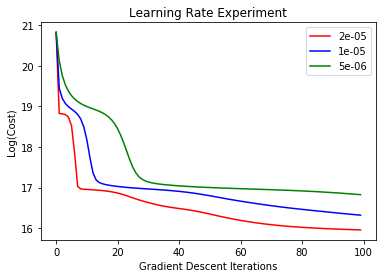

In [77]:
colors = ['r', 'b', 'g']
title = 'Learning Rate'
print('Using Optimizer:',opt.__class__.__name__)
plot_experiment(costs, epochs, lrs, title, colors)

In [78]:
# Run best LR with SGD for more epochs to get best SGD v
epochs = 500
lrs = [.00002]
costs =[]
for lr in lrs:
    model = MovieCost()
    model.to(device)
    print('LR:',lr)
    opt = optim.SGD(model.parameters(), lr=lr)
    costs.append(fit(X, model, opt, epochs))

LR: 2e-05
Step 0 Cost 1098758656.0
Step 20 Cost 21943068.0
Step 40 Cost 14047007.0
Step 60 Cost 10528105.0
Step 80 Cost 9124958.0
Step 100 Cost 8456797.0
Step 120 Cost 8211713.0
Step 140 Cost 8147657.0
Step 160 Cost 8120781.0
Step 180 Cost 8104218.0
Step 200 Cost 8093021.0
Step 220 Cost 8085252.5
Step 240 Cost 8079796.5
Step 260 Cost 8075925.0
Step 280 Cost 8073145.5
Step 300 Cost 8071125.0
Step 320 Cost 8069634.5
Step 340 Cost 8068521.5
Step 360 Cost 8067679.5
Step 380 Cost 8067035.0
Step 400 Cost 8066537.5
Step 420 Cost 8066150.0
Step 440 Cost 8065846.0
Step 460 Cost 8065606.0
Step 480 Cost 8065416.5


Using Optimizer: SGD


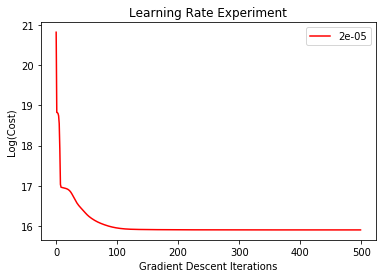

In [79]:
colors = ['r', 'b', 'g']
title = 'Learning Rate'
print('Using Optimizer:',opt.__class__.__name__)
plot_experiment(costs, epochs, lrs, title, colors)

In [141]:
#Save best model parameters for SGD for use later: tensor v embedding our movie likes
SGDbest_v = [p for p in model.parameters()][0]
SGDbest_v.requires_grad=False
print(SGDbest_v.size())

torch.Size([9742, 9742])


In [93]:
# Try Adam with several LRs
epochs = 200
lrs = [1, .7, .5]
costs =[]
for lr in lrs:
    model = MovieCost()
    model.to(device)
    print('LR:',lr)
    opt = optim.Adam(model.parameters(), lr=lr)
    costs.append(fit(X, model, opt, epochs))

LR: 1
Step 0 Cost 9651146752.0
Step 20 Cost 214087888.0
Step 40 Cost 26146722.0
Step 60 Cost 7090647.0
Step 80 Cost 2922103.0
Step 100 Cost 1600506.75
Step 120 Cost 1182372.25
Step 140 Cost 1095166.5
Step 160 Cost 1070258.0
Step 180 Cost 1061098.25
LR: 0.7
Step 0 Cost 9650829312.0
Step 20 Cost 160835568.0
Step 40 Cost 22820898.0
Step 60 Cost 6757683.0
Step 80 Cost 3003609.5
Step 100 Cost 1716388.875
Step 120 Cost 1244033.75
Step 140 Cost 1109289.75
Step 160 Cost 1077213.25
Step 180 Cost 1065698.0
LR: 0.5
Step 0 Cost 9655267328.0
Step 20 Cost 153283872.0
Step 40 Cost 21694720.0
Step 60 Cost 6988811.0
Step 80 Cost 3329576.25
Step 100 Cost 1983600.625
Step 120 Cost 1407242.0
Step 140 Cost 1173841.375
Step 160 Cost 1101364.0
Step 180 Cost 1079909.25


Using Optimizer: Adam


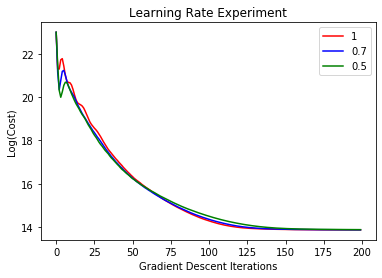

In [94]:
colors = ['r', 'b', 'g', 'm']
title = 'Learning Rate'
print('Using Optimizer:',opt.__class__.__name__)
plot_experiment(costs, epochs, lrs, title, colors)

From the above experiments, Adam with LR=.5 is best, not only in raw performance over 100 epochs, but also in that Adam can take much higher LRs than than SGD (a LR greater than .002 causes divergence) and thus converges much faster. Consequently, next we further train using Adam, LR=.5 and 500 epochs.

In [144]:
# Improve best model (Adam, LR=.5) with more epochs
epochs = 500
lrs = [.5]
costs =[]
for lr in lrs:
    model = MovieCost()
    model.to(device)
    print('LR:',lr)
    opt = optim.Adam(model.parameters(), lr=lr)
    costs.append(fit(X, model, opt, epochs))

LR: 0.5
Step 0 Cost 242560608.0
Step 20 Cost 10574404.0
Step 40 Cost 1358980.375
Step 60 Cost 176011.953125
Step 80 Cost 23600.005859375
Step 100 Cost 3153.533203125
Step 120 Cost 590.6942138671875
Step 140 Cost 303.9716796875
Step 160 Cost 325.2000427246094
Step 180 Cost 380.2244873046875
Step 200 Cost 436.64862060546875
Step 220 Cost 503.97467041015625
Step 240 Cost 787.1342163085938
Step 260 Cost 845.3270263671875
Step 280 Cost 871.69775390625
Step 300 Cost 869.3186645507812
Step 320 Cost 912.54541015625
Step 340 Cost 918.2579345703125
Step 360 Cost 924.7154541015625
Step 380 Cost 903.2702026367188
Step 400 Cost 897.050048828125
Step 420 Cost 897.6204833984375
Step 440 Cost 863.269287109375
Step 460 Cost 853.2183837890625
Step 480 Cost 858.2890014648438


Using Optimizer: Adam


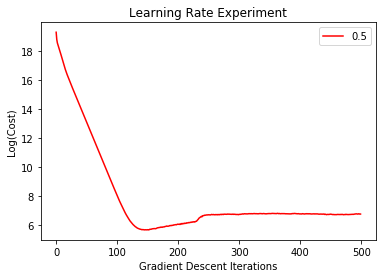

In [145]:
colors = ['r', 'b', 'g', 'm']
title = 'Learning Rate'
print('Using Optimizer:',opt.__class__.__name__)
plot_experiment(costs, epochs, lrs, title, colors)

In [146]:
# Trying again, with epochs = 120 to match the minima above
epochs = 120
lrs = [.5]
costs =[]
for lr in lrs:
    model = MovieCost()
    model.to(device)
    print('LR:',lr)
    opt = optim.Adam(model.parameters(), lr=lr)
    costs.append(fit(X, model, opt, epochs))

LR: 0.5
Step 0 Cost 242454256.0
Step 20 Cost 10667440.0
Step 40 Cost 1359373.625
Step 60 Cost 177841.625
Step 80 Cost 23311.017578125
Step 100 Cost 3144.6767578125


Using Optimizer: Adam


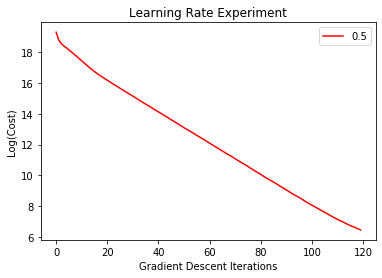

In [147]:
colors = ['r', 'b', 'g', 'm']
title = 'Learning Rate'
print('Using Optimizer:',opt.__class__.__name__)
plot_experiment(costs, epochs, lrs, title, colors)

In [95]:
#Save best model parameters: tensor v embedding our movie likes
best_v = [p for p in model.parameters()][0]
best_v.requires_grad=False
print(best_v.size())

torch.Size([100, 9742])


#### 2.3. Recommend top 10 movies (not vectors or indices but movie names) given movies (a) ‘Apollo 13’, (b) ‘Toy Story’, and (c) ‘Home Alone’ . Describe your recommendation strategy. Do the recommendations change when you change learning rates or optimizers? Why or why not?

In [96]:
# The similarity matrix is simply the dot product of the v and it's transpose  
dot_sim_matrix = best_v.transpose(0,1) @ best_v
mask = mask.to(device)
dot_sim_matrix.masked_fill_(mask, 0)
dot_sim_matrix.shape

torch.Size([9742, 9742])

#### 2.3.(a,b,c) Top 10s for given movies

In [122]:
def topksimilar(keys, similarity_matrix, index2namedict, k=10):
    for key in keys:
        # Determine index corresponding to partial title in key
        key_idx = df_m.index[df_m['title'].str.contains(key+' \(')]

        # Extract matching row from similarity matrix and get top 10 values and indices
        a = similarity_matrix[key_idx]
        values, indices = torch.topk(a, k)

        # Print results
        print('Top {0} Matches for {1}'.format(k, key))
        for i, (score, idx) in enumerate(zip(values[0], indices[0])):
            # Use dict defined earlier to convert from index to title
            title = index2namedict[idx.item()]
            print('{0:4} {1:6.1f} {2:3} - {3}'.format(idx.item(), np.trunc(score.item()), i+1, title))
        print()

In [125]:
keys = ['Fargo']
index2namedict = index2movietitle
similarity_matrix = dot_sim_matrix
topksimilar(keys, similarity_matrix, index2namedict, k=100)

Top 100 Matches for Fargo
 257  110.0   1 - Pulp Fiction (1994)
 510   99.0   2 - Silence of the Lambs, The (1991)
 277   96.0   3 - Shawshank Redemption, The (1994)
  46   92.0   4 - Usual Suspects, The (1995)
 224   90.0   5 - Star Wars: Episode IV - A New Hope (1977)
 659   86.0   6 - Godfather, The (1972)
 314   81.0   7 - Forrest Gump (1994)
2226   80.0   8 - Fight Club (1999)
2145   79.0   9 - American Beauty (1999)
1939   78.0  10 - Matrix, The (1999)
 898   77.0  11 - Star Wars: Episode V - The Empire Strikes Back (1980)
 900   76.0  12 - Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
  43   75.0  13 - Seven (a.k.a. Se7en) (1995)
  31   75.0  14 - Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
 828   74.0  15 - Reservoir Dogs (1992)
 461   74.0  16 - Schindler's List (1993)
 863   70.0  17 - Monty Python and the Holy Grail (1975)
   0   68.0  18 - Toy Story (1995)
 507   68.0  19 - Terminator 2: Judgment Day (1991)
 914   67.0  20 - Goodfellas (1990)


In [152]:
keys = ['Apollo 13', 'Toy Story', 'Home Alone']

for key in keys:
    # Determine index corresponding to partial title in key
    key_idx = df_m.index[df_m['title'].str.contains(key+' \(')]

    # Extract matching row from similarity matrix and get top 10 values and indices
    a = dot_sim_matrix[key_idx]
    values, indices = torch.topk(a, 10)

    # Print results
    print('Top 10 Matches for', key)
    for i, (score, idx) in enumerate(zip(values[0], indices[0])):
        # Use dict defined earlier to convert from index to title
        title = index2movietitle[idx.item()]
        print(idx.item(), np.trunc(score.item()),'\t',i+1,'-', title)
    print()

Top 10 Matches for Apollo 13
257 1739.0 	 1 - Pulp Fiction (1994)
1211 1323.0 	 2 - Hunt for Red October, The (1990)
6062 1269.0 	 3 - Harry Potter and the Goblet of Fire (2005)
2372 1196.0 	 4 - Green Mile, The (1999)
990 1190.0 	 5 - Indiana Jones and the Last Crusade (1989)
485 1127.0 	 6 - Tombstone (1993)
905 1118.0 	 7 - 12 Angry Men (1957)
958 1048.0 	 8 - Stand by Me (1986)
943 1048.0 	 9 - Manhattan (1979)
2996 1009.0 	 10 - Snatch (2000)

Top 10 Matches for Toy Story
136 1784.0 	 1 - Desperado (1995)
2222 1725.0 	 2 - Fistful of Dollars, A (Per un pugno di dollari) (1964)
2982 1660.0 	 3 - Unbreakable (2000)
780 1524.0 	 4 - Cinderella (1950)
1067 1427.0 	 5 - Jaws (1975)
911 1368.0 	 6 - Star Wars: Episode VI - Return of the Jedi (1983)
969 1325.0 	 7 - Back to the Future (1985)
6330 1318.0 	 8 - Children of Men (2006)
2250 1283.0 	 9 - Who Framed Roger Rabbit? (1988)
4360 1276.0 	 10 - Finding Nemo (2003)

Top 10 Matches for Home Alone
3141 1272.0 	 1 - Memento (2000)
383 1

#### Try again with best SGD v

In [153]:
# The similarity matrix is simply the dot product of the v and it's transpose  
dot_sim_matrix = SGDbest_v.transpose(0,1) @ SGDbest_v
dot_sim_matrix.masked_fill_(mask, 0)

tensor([[   0.0000, -360.9445,  505.0954,  ...,   31.1583, -216.9703,
          222.6164],
        [-360.9445,    0.0000, -489.1485,  ..., -142.0982, -206.3832,
         -101.9904],
        [ 505.0954, -489.1485,    0.0000,  ...,   64.5142,   48.5351,
          -28.4190],
        ...,
        [  31.1583, -142.0982,   64.5142,  ...,    0.0000,  -75.0963,
          170.2028],
        [-216.9703, -206.3832,   48.5351,  ...,  -75.0963,    0.0000,
          -45.8920],
        [ 222.6164, -101.9904,  -28.4190,  ...,  170.2028,  -45.8920,
            0.0000]], device='cuda:0')

In [154]:
keys = ['Apollo 13', 'Toy Story', 'Home Alone']

for key in keys:
    # Determine index corresponding to partial title in key
    key_idx = df_m.index[df_m['title'].str.contains(key+' \(')]

    # Extract matching row from similarity matrix and get top 10 values and indices
    a = dot_sim_matrix[key_idx]
    values, indices = torch.topk(a, 10)

    # Print results
    print('Top 10 Matches for', key)
    for i, (score, idx) in enumerate(zip(values[0], indices[0])):
        # Use dict defined earlier to convert from index to title
        title = index2movietitle[idx.item()]
        print(idx.item(), np.trunc(score.item()),'\t',i+1,'-', title)
    print()

Top 10 Matches for Apollo 13
43 1975.0 	 1 - Seven (a.k.a. Se7en) (1995)
2145 1661.0 	 2 - American Beauty (1999)
964 1638.0 	 3 - Groundhog Day (1993)
911 1429.0 	 4 - Star Wars: Episode VI - Return of the Jedi (1983)
613 1402.0 	 5 - Trainspotting (1996)
914 1356.0 	 6 - Goodfellas (1990)
1071 1180.0 	 7 - Mars Attacks! (1996)
659 1170.0 	 8 - Godfather, The (1972)
969 1151.0 	 9 - Back to the Future (1985)
2226 1134.0 	 10 - Fight Club (1999)

Top 10 Matches for Toy Story
4615 1839.0 	 1 - Kill Bill: Vol. 1 (2003)
939 1770.0 	 2 - Terminator, The (1984)
990 1767.0 	 3 - Indiana Jones and the Last Crusade (1989)
97 1471.0 	 4 - Braveheart (1995)
506 1457.0 	 5 - Aladdin (1992)
337 1292.0 	 6 - True Lies (1994)
903 1249.0 	 7 - Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)
969 1240.0 	 8 - Back to the Future (1985)
43 1201.0 	 9 - Seven (a.k.a. Se7en) (1995)
1022 1164.0 	 10 - Birds, The (1963)

Top 10 Matches for Home Alone
1939 1093.0 	 1 - Matrix, The (1

In general, the Adam optimized parameters seem to predict more logical movies than the SGD based parameters. This is likely due to the much better cost reduction by Adam (<1000) vs SGD (~300K). I expect that SGD could achieve similar results to Adam if a lower LR was used with many, many more gradient descent steps. Given the observed difference in performance between the two, I'm very much inclined to start with Adam next time!